In [1]:
!nvidia-smi

Thu May 19 18:43:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.67       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:65:00.0 Off |                  N/A |
| 63%   54C    P2   133W / 370W |  22331MiB / 24265MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:B3:00.0 Off |                  N/A |
|  0%   

In [2]:
from transformation import *
from utilities import *
from calculate_disparity import *
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2 as cv
import warnings
import skimage.transform as st
import gc
import os

print(tf.__version__)
warnings.filterwarnings("ignore")

gpus = tf.config.list_physical_devices(device_type='GPU')
tf.config.set_visible_devices(devices=gpus[1], device_type='GPU')

2.8.0


In [3]:
seed = 2021
os.environ['PYTHONHASHSEED']=str(seed)
tf.random.set_seed(seed)
np.random.seed(seed)
Labels_diseases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']

In [4]:
def get_data(dataset='mimic', data_split='test', types='race', feature_type=-1, random_aug=False):
    np.random.seed(2021)
    
    X = []
    y = []
    if (dataset == 'mimic'):
        if (random_aug == True):
            if (data_split == 'train'):
                filename = 'data/mimic_train_transformed.tfrecords'
            elif(data_split == 'val'):
                filename = 'data/mimic_val_transformed.tfrecords'
            else:
                filename = 'data/mimic_test_transformed.tfrecords'
        else:
            if (data_split == 'train'):
                filename = 'data/mimic_train.tfrecords'
            elif(data_split == 'val'):
                filename = 'data/mimic_val.tfrecords'
            else:
                filename = 'data/mimic_test.tfrecords'
                
    elif (dataset == 'chexpert'):
        if (random_aug == True):
            if (data_split == 'train'):
                filename = 'data/Chexpert_train_transformed.tfrecords'
            elif(data_split == 'val'):
                filename = 'data/Chexpert_val_transformed.tfrecords'
            else:
                filename = 'data/Chexpert_test_transformed.tfrecords'
        if (data_split == 'train'):
            filename = '../Data/Chexpert_train.tfrecords'
        elif(data_split == 'val'):
            filename = '../Data/Chexpert_val.tfrecords'
        else:
            filename = '../Data/Chexpert_test.tfrecords'
        
    raw_dataset = tf.data.TFRecordDataset(filename)
    for raw_record in raw_dataset:
        sub_y = []

        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        
        race = example.features.feature['race'].int64_list.value[0]
        
        if (types == 'race'):
            feature = race
        elif (types == 'age'):
            age = example.features.feature['age'].int64_list.value[0]
            if (age > 0):
                age -= 1
            feature = age
        else:
            gender = example.features.feature['gender'].int64_list.value[0]
            feature = gender

        
        if not (race == 0 or race == 1 or race == 4):
            continue
            
        if (feature_type == -1 or feature == feature_type):

            sub_y.append(1 if example.features.feature['Atelectasis'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Cardiomegaly'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Consolidation'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Edema'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Enlarged Cardiomediastinum'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Fracture'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Lung Lesion'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Lung Opacity'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['No Finding'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Pleural Effusion'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Pleural Other'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Pneumonia'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Pneumothorax'].float_list.value[0] == 1 else 0)
            sub_y.append(1 if example.features.feature['Support Devices'].float_list.value[0] == 1 else 0)
            
            nparr = np.fromstring(example.features.feature['jpg_bytes'].bytes_list.value[0], np.uint8)
            img_np = cv.imdecode(nparr, cv.IMREAD_GRAYSCALE)

            X.append(np.float32(st.resize(img_np, (224, 224))))
            y.append(sub_y)
    
    return np.array(X), np.array(y)

# Radiological labels Detection

In [3]:
INPUT_SHAPE = (128, 128, 1)
def define_model_diseases():
    
    input = tf.keras.layers.Input(shape=INPUT_SHAPE)
    
    reshape_layer = tf.keras.layers.UpSampling3D(size=(1,1,3))(input)
    
    base_model = tf.keras.applications.densenet.DenseNet121(
            include_top=False, weights='imagenet', input_shape=(128, 128, 3), pooling='max')(reshape_layer)
         
    pred_layer = tf.keras.layers.Dense(14, activation='sigmoid')(base_model)
 
    model = tf.keras.Model(inputs=input, outputs=pred_layer)
    
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics='AUC')
  
    return model

model = define_model_diseases()

model.load_weights('checkpoints/model_mimic_128')

In [4]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 up_sampling3d (UpSampling3D  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 14)                14350     
                                                                 
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________


In [6]:
checkpoint_filepath = 'checkpoints/model_mimic_128'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.EarlyStopping(mode='min', patience=4, monitor='val_loss'),
            model_checkpoint_callback]

# mimic
X_train, y_train = get_data(dataset='mimic', data_split='train', types='race', feature_type=-1, random_aug=False)
X_val, y_val = get_data(dataset='mimic', data_split='val', types='race', feature_type=-1, random_aug=False)

# chexpert
# X_train, y_train = get_data(dataset='chexpert', data_split='train', types='race', feature_type=-1, random_aug=True)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2021)

model = define_model_diseases()

model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=callback, batch_size=BATCH_SIZE)

# y_preds = model.predict(X_val)

# best_thresh = cal_best_thresh(y_val, y_preds)

# np.savetxt('mimic_proposed_thresh.txt', [best_thresh])

# del X_train, y_train
# del X_val, y_val
# gc.collect()

Epoch 1/15
910/910 [==============================] - 145s 147ms/step - loss: 0.3011 - auc: 0.8440 - val_loss: 0.7555 - val_auc: 0.7755 - lr: 9.5123e-04
Epoch 2/15
910/910 [==============================] - 131s 144ms/step - loss: 0.2853 - auc: 0.8596 - val_loss: 0.3995 - val_auc: 0.7836 - lr: 9.5123e-04
Epoch 3/15
910/910 [==============================] - 131s 144ms/step - loss: 0.2905 - auc: 0.8549 - val_loss: 0.3954 - val_auc: 0.7479 - lr: 9.0484e-04
Epoch 4/15
265/910 [=======>......................] - ETA: 1:28 - loss: 0.2893 - auc: 0.8559

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



910/910 [==============================] - 131s 144ms/step - loss: 0.2869 - auc: 0.8587 - val_loss: 0.2964 - val_auc: 0.8474 - lr: 8.6071e-04
Epoch 6/15
910/910 [==============================] - 131s 144ms/step - loss: 0.2878 - auc: 0.8575 - val_loss: 0.4292 - val_auc: 0.8262 - lr: 8.6071e-04
Epoch 7/15
910/910 [==============================] - 132s 146ms/step - loss: 0.2798 - auc: 0.8662 - val_loss: 0.3193 - val_auc: 0.8644 - lr: 8.1873e-04
Epoch 8/15
910/910 [==============================] - 132s 145ms/step - loss: 0.2742 - auc: 0.8722 - val_loss: 0.2818 - val_auc: 0.8695 - lr: 8.1873e-04
Epoch 9/15
910/910 [==============================] - 131s 144ms/step - loss: 0.2710 - auc: 0.8757 - val_loss: 0.4327 - val_auc: 0.8235 - lr: 7.7880e-04
Epoch 10/15
910/910 [==============================] - 131s 144ms/step - loss: 0.2771 - auc: 0.8696 - val_loss: 0.3285 - val_auc: 0.8372 - lr: 7.7880e-04
Epoch 11/15
417/910 [============>.................] - ETA: 1:07 - loss: 0.2698 - auc: 0.877

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



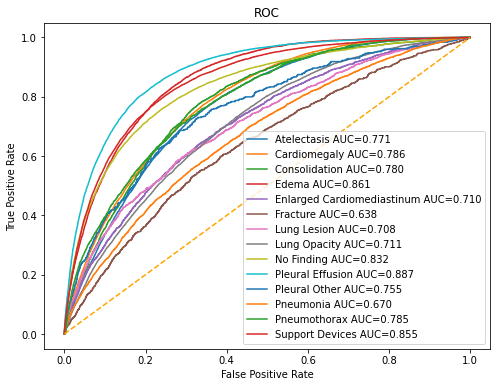

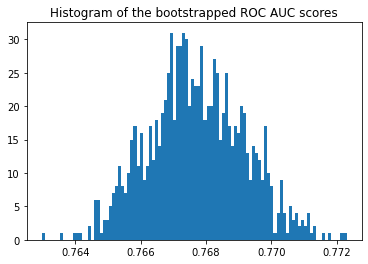

Sample auc mean: 0.768
Samole auc std: 0.001
Sample auc CI: 0.003
Confidence interval for the score: [0.764 - 0.771]
0.7677120235273877


In [7]:
X_test, y_test = get_data(dataset='mimic', data_split='test', types='race', feature_type=-1, random_aug=False)

model = define_model_diseases()

model.load_weights('checkpoints/model_mimic_128')
y_preds = model.predict(X_test)
plot_roc(y_test, y_preds, 'ROC', Labels_diseases)
print(test(y_preds, y_test))

In [4]:
model = tf.keras.models.load_model('model_mimic_128.h5')

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 up_sampling3d (UpSampling3D  (None, 128, 128, 3)      0         
 )                                                               
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 14)                14350     
                                                                 
Total params: 7,051,854
Trainable params: 6,968,206
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
X_test, y_test = get_data(dataset='mimic', data_split='test', types='race', feature_type=-1, random_aug=False)

model = define_model_diseases()

model.load_weights('checkpoints/model_mimic_baseline')
y_preds = model.predict(X_test)
plot_roc(y_test, y_preds, 'ROC', Labels_diseases)
print(test(y_preds, y_test))

# model.load_weights('checkpoints/model_mimic_proposed')
# y_preds = model.predict(X_test)
# plot_roc(y_test, y_preds, 'ROC', Labels_diseases)
# print(test(y_preds, y_test))

# model.load_weights('checkpoints/model_chexpert_baseline')
# y_preds = model.predict(X_test)
# plot_roc(y_test, y_preds, 'ROC', Labels_diseases)
# print(test(y_preds, y_test))

# model.load_weights('checkpoints/model_chexpert_proposed')
# y_preds = model.predict(X_test)
# plot_roc(y_test, y_preds, 'ROC', Labels_diseases)
# print(test(y_preds, y_test))

del model 
gc.collect()

# Calculate TPR Disparity

In [5]:
model = define_model_diseases()

# model.load_weights('checkpoints/model_mimic_baseline')
# best_thresh = np.loadtxt('mimic_baseline_thresh.txt')

# model.load_weights('checkpoints/model_mimic_proposed')
# best_thresh = np.loadtxt('mimic_proposed_thresh.txt')

# model.load_weights('checkpoints/model_chexpert_baseline')
# best_thresh = np.loadtxt('chexpert_baseline_thresh.txt')

model.load_weights('checkpoints/model_chexpert_proposed')
best_thresh = np.loadtxt('chexpert_proposed_thresh.txt')

## Race

In [6]:
random_aug = False
X_test_white, y_test_white = get_data('mimic', 'test', 'race', 0, random_aug)
X_test_black, y_test_black = get_data('mimic', 'test', 'race', 1, random_aug)
X_test_asia, y_test_asia = get_data('mimic', 'test', 'race', 4, random_aug)

In [7]:
y_preds_white = model.predict(X_test_white)
y_preds_black = model.predict(X_test_black)
y_preds_asia = model.predict(X_test_asia)

In [8]:
disparity = []
tprs_white = []
tprs_black = []
tprs_asia = []
for i in range(14):
    tpr_white = get_tpr(y_test_white[:, i], y_preds_white[:, i], best_thresh[i])
    tpr_black = get_tpr(y_test_black[:, i], y_preds_black[:, i], best_thresh[i])
    tpr_asia = get_tpr(y_test_asia[:, i], y_preds_asia[:, i], best_thresh[i])

    median = np.median([tpr_white, tpr_black, tpr_asia])
    gap = np.abs(tpr_white-median) + np.abs(tpr_black-median) + np.abs(tpr_asia-median)
    disparity.append(gap)
    tprs_white.append(tpr_white)
    tprs_black.append(tpr_black)
    tprs_asia.append(tpr_asia)
    
result = []
result.append(disparity)
result.append(tprs_white)
result.append(tprs_black)
result.append(tprs_asia)

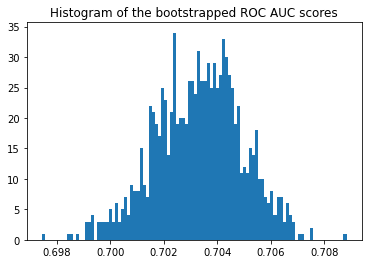

Sample auc mean: 0.703
Samole auc std: 0.002
Sample auc CI: 0.004
Confidence interval for the score: [0.700 - 0.707]
0.7033057531192152


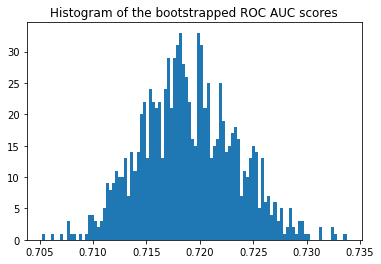

Sample auc mean: 0.719
Samole auc std: 0.004
Sample auc CI: 0.010
Confidence interval for the score: [0.709 - 0.729]
0.7189377182567748


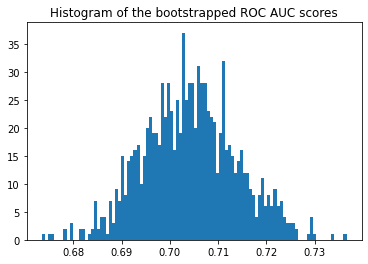

Sample auc mean: 0.704
Samole auc std: 0.010
Sample auc CI: 0.022
Confidence interval for the score: [0.682 - 0.726]
0.7041790490367977


In [9]:
print(test(y_preds_white, y_test_white))
print(test(y_preds_black, y_test_black))
print(test(y_preds_asia, y_test_asia))

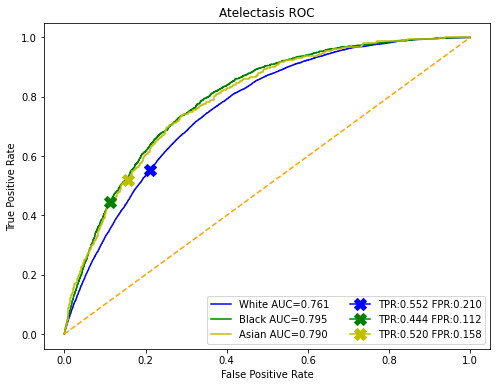

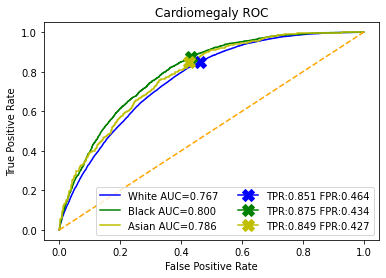

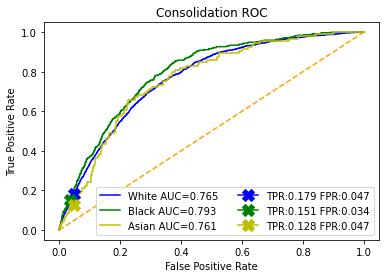

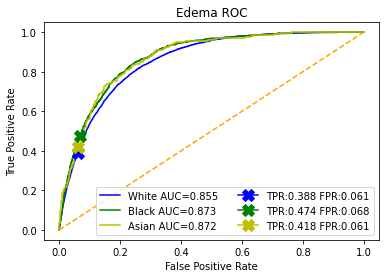

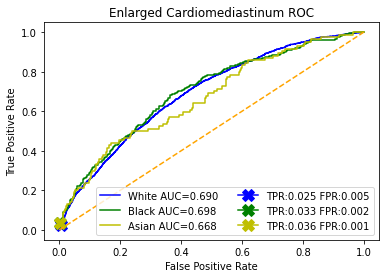

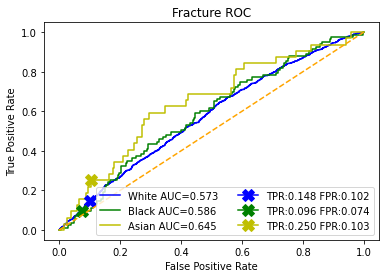

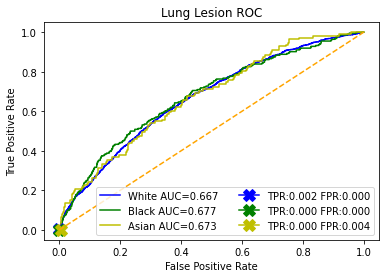

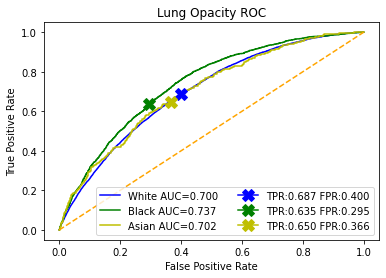

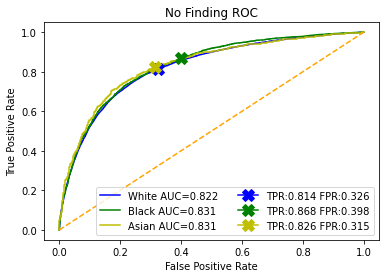

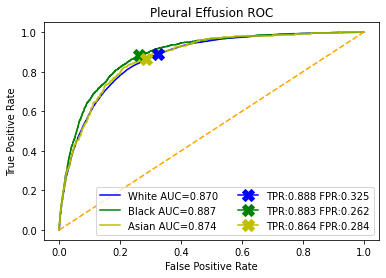

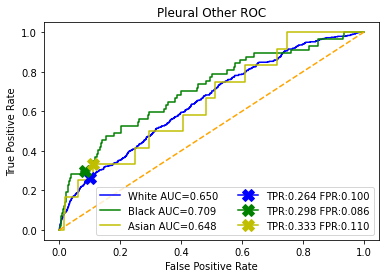

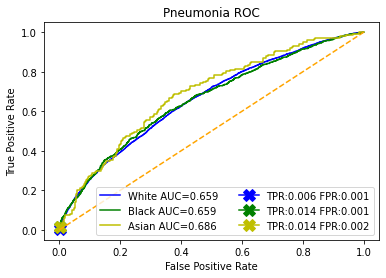

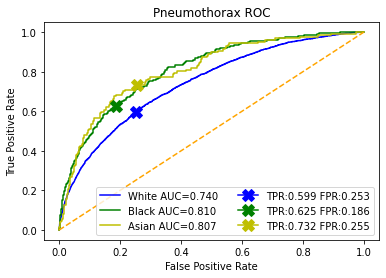

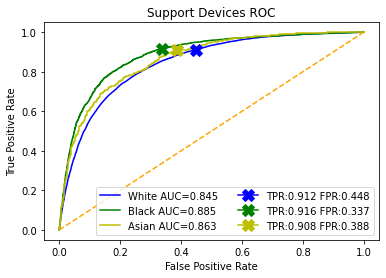

In [17]:
fig = plt.figure(figsize=(8,6))
# target_label = 4
for target_label in range(14):
    fpr, tpr, _ = roc_curve(y_test_white[:, target_label], y_preds_white[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='b', label='{} AUC={:.3f}'.format('White', roc_auc))

    fpr, tpr, _ = roc_curve(y_test_black[:, target_label], y_preds_black[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='g', label='{} AUC={:.3f}'.format('Black', roc_auc))

    fpr, tpr, _ = roc_curve(y_test_asia[:, target_label], y_preds_asia[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='y', label='{} AUC={:.3f}'.format('Asian', roc_auc))


    fpr, tpr, _ = roc_curve(y_test_white[:, target_label], y_preds_white[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='b', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))

    fpr, tpr, _ = roc_curve(y_test_black[:, target_label], y_preds_black[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='g', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))

    fpr, tpr, _ = roc_curve(y_test_asia[:, target_label], y_preds_asia[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='y', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC'.format(Labels_diseases[target_label]))
    plt.legend(loc="lower right", ncol=2)
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    plt.savefig('MIMICbaseline_MIMICaug/{} ROC.jpg'.format(Labels_diseases[target_label]))

    plt.show()

## Age

In [9]:
random_aug = False

X_test_age0, y_test_age0 = get_data('mimic', 'test', 'age', 0, random_aug)
X_test_age1, y_test_age1 = get_data('mimic', 'test', 'age', 1, random_aug)
X_test_age2, y_test_age2 = get_data('mimic', 'test', 'age', 2, random_aug)
X_test_age3, y_test_age3 = get_data('mimic', 'test', 'age', 3, random_aug)

In [18]:
y_preds_age0 = model.predict(X_test_age0)
y_preds_age1 = model.predict(X_test_age1)
y_preds_age2 = model.predict(X_test_age2)
y_preds_age3 = model.predict(X_test_age3)

In [17]:
disparity = []
tprs_age0 = []
tprs_age1 = []
tprs_age2 = []
tprs_age3 = []
for i in range(14):
    tpr_age0 = get_tpr(y_test_age0[:, i], y_preds_age0[:, i], best_thresh[i])
    tpr_age1 = get_tpr(y_test_age1[:, i], y_preds_age1[:, i], best_thresh[i])
    tpr_age2 = get_tpr(y_test_age2[:, i], y_preds_age2[:, i], best_thresh[i])
    tpr_age3 = get_tpr(y_test_age3[:, i], y_preds_age3[:, i], best_thresh[i])

    median = np.median([tpr_age0, tpr_age1, tpr_age2, tpr_age3])
    gap = np.abs(tpr_age0-median) + np.abs(tpr_age1-median) + np.abs(tpr_age2-median) + np.abs(tpr_age3-median)
    disparity.append(gap)
    tprs_age0.append(tpr_age0)
    tprs_age1.append(tpr_age1)
    tprs_age2.append(tpr_age2)
    tprs_age3.append(tpr_age3)
    
result = []
result.append(disparity)
result.append(tprs_age0)
result.append(tprs_age1)
result.append(tprs_age2)
result.append(tprs_age3)

In [ ]:
print(test(y_preds_age0, y_test_age0))
print(test(y_preds_age1, y_test_age1))
print(test(y_preds_age2, y_test_age2))
print(test(y_preds_age3, y_test_age3))

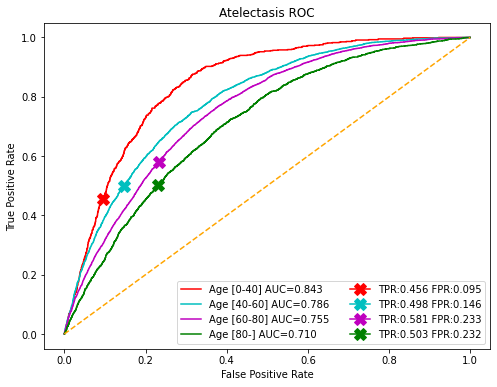

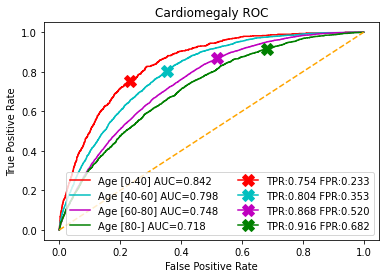

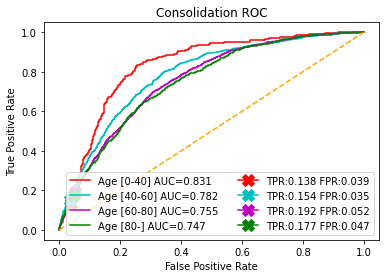

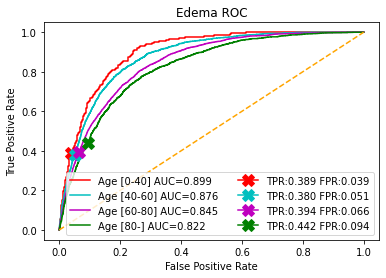

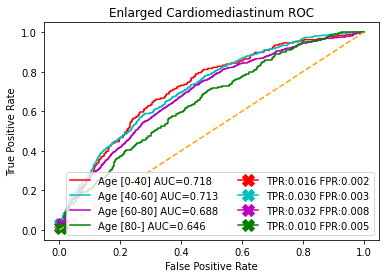

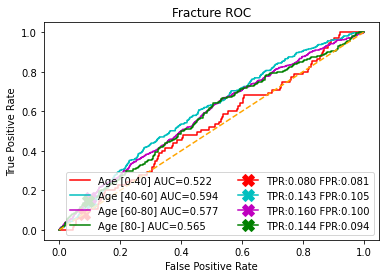

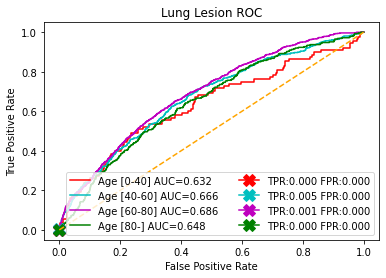

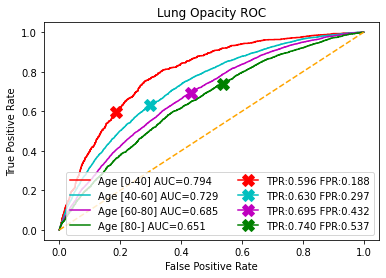

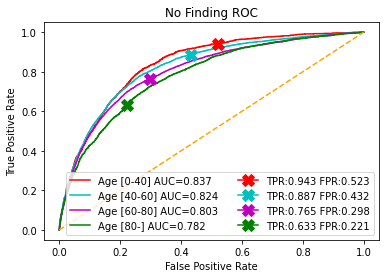

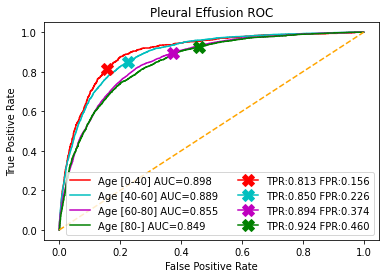

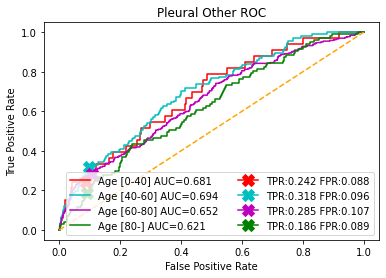

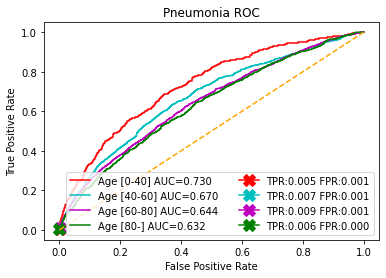

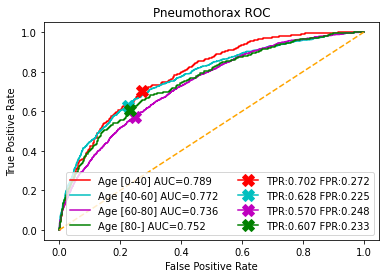

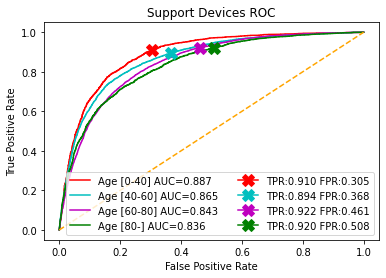

In [19]:
fig = plt.figure(figsize=(8,6))
target_label = 4

for target_label in range(14):
    fpr, tpr, _ = roc_curve(y_test_age0[:, target_label], y_preds_age0[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='r', label='{} AUC={:.3f}'.format('Age [0-40]', roc_auc))

    fpr, tpr, _ = roc_curve(y_test_age1[:, target_label], y_preds_age1[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='c', label='{} AUC={:.3f}'.format('Age [40-60]', roc_auc))

    fpr, tpr, _ = roc_curve(y_test_age2[:, target_label], y_preds_age2[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='m', label='{} AUC={:.3f}'.format('Age [60-80]', roc_auc))

    fpr, tpr, _ = roc_curve(y_test_age3[:, target_label], y_preds_age3[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='g', label='{} AUC={:.3f}'.format('Age [80-]', roc_auc))


    fpr, tpr, _ = roc_curve(y_test_age0[:, target_label], y_preds_age0[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='r', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))

    fpr, tpr, _ = roc_curve(y_test_age1[:, target_label], y_preds_age1[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='c', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))

    fpr, tpr, _ = roc_curve(y_test_age2[:, target_label], y_preds_age2[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='m', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))

    fpr, tpr, _ = roc_curve(y_test_age3[:, target_label], y_preds_age3[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='g', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))


    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC'.format(Labels_diseases[target_label]))
    plt.legend(loc="lower right", ncol=2)
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    plt.savefig('MIMICbaseline_MIMICaug/{} ROC age.jpg'.format(Labels_diseases[target_label]))

    plt.show()

## Gender

In [12]:
random_aug = False

X_test_male, y_test_male = get_data('mimic', 'test', 'gender', 0, random_aug)
X_test_female, y_test_female = get_data('mimic', 'test', 'gender', 1, random_aug)

In [20]:
y_preds_male = model.predict(X_test_male)
y_preds_female = model.predict(X_test_female)

In [ ]:
disparity = []
tprs_male = []
tprs_female = []
for i in range(14):
    tpr_male = get_tpr(y_test_male[:, i], y_preds_male[:, i], best_thresh[i])
    tpr_female = get_tpr(y_test_female[:, i], y_preds_female[:, i], best_thresh[i])

    gap = np.abs(tpr_male-tpr_female)
    disparity.append(gap)
    tprs_male.append(tpr_male)
    tprs_female.append(tpr_female)

result = []
result.append(disparity)
result.append(tprs_male)
result.append(tprs_female)

In [ ]:
print(test(y_preds_male, y_test_male))
print(test(y_preds_female, y_test_female))

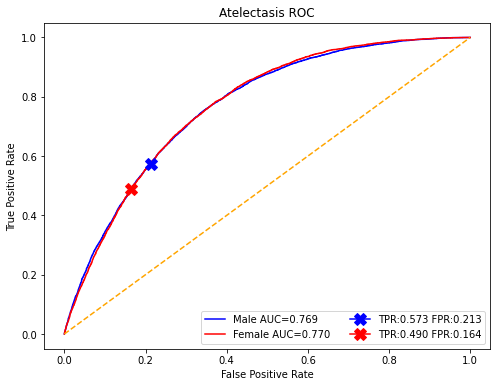

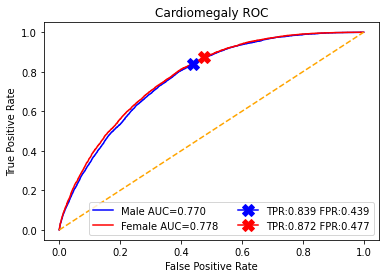

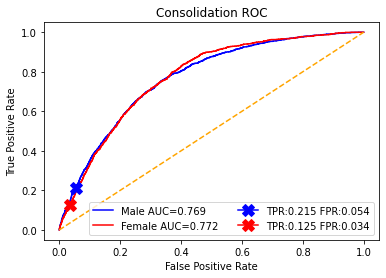

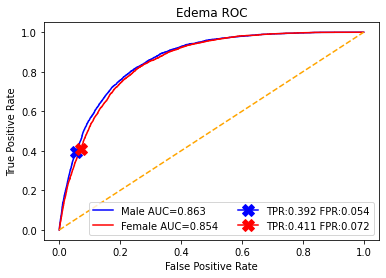

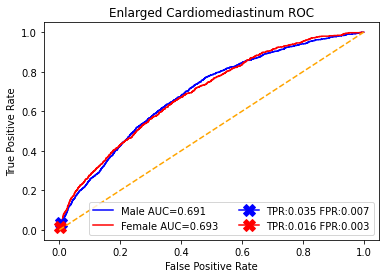

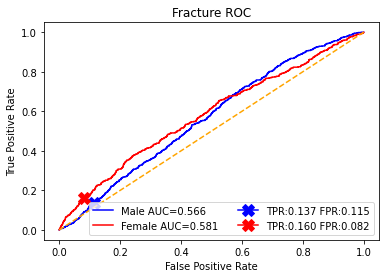

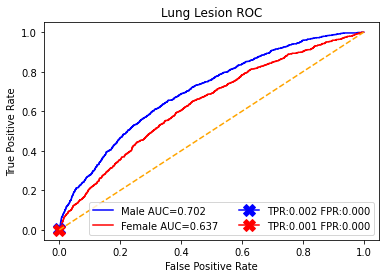

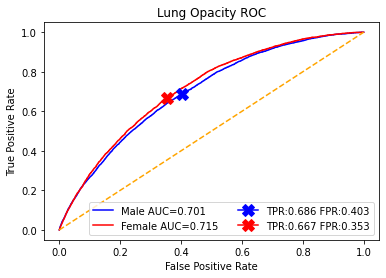

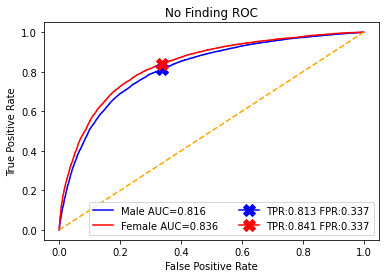

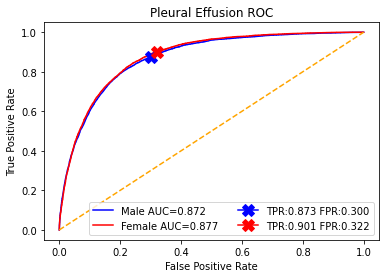

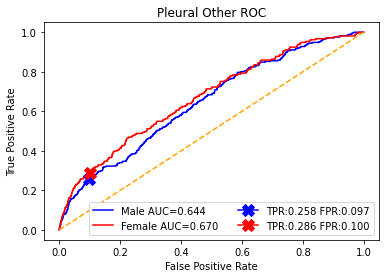

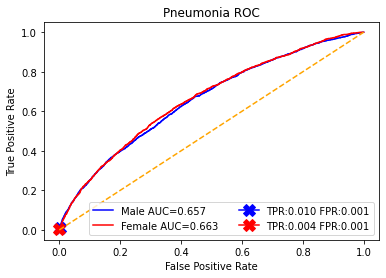

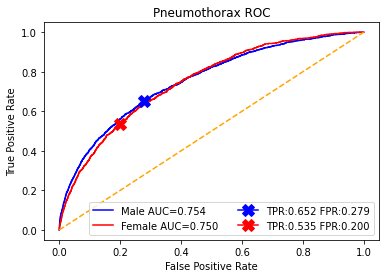

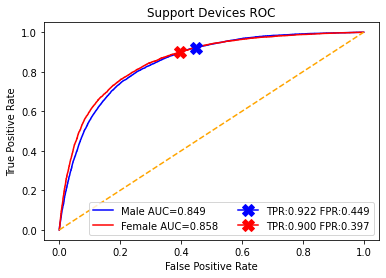

In [21]:
fig = plt.figure(figsize=(8,6))
target_label = 4

for target_label in range(14):
    fpr, tpr, _ = roc_curve(y_test_male[:, target_label], y_preds_male[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='b', label='{} AUC={:.3f}'.format('Male', roc_auc))

    fpr, tpr, _ = roc_curve(y_test_female[:, target_label], y_preds_female[:, target_label])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linestyle='solid', color='r', label='{} AUC={:.3f}'.format('Female', roc_auc))


    fpr, tpr, _ = roc_curve(y_test_male[:, target_label], y_preds_male[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='b', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))

    fpr, tpr, _ = roc_curve(y_test_female[:, target_label], y_preds_female[:, target_label])
    roc_auc = auc(fpr, tpr)
    idx = find_nearest(_, best_thresh[target_label])
    plt.plot(fpr[idx], tpr[idx], marker='X', color='r', markersize=12, label='TPR:{:.3f} FPR:{:.3f}'.format(tpr[idx], fpr[idx]))



    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{} ROC'.format(Labels_diseases[target_label]))
    plt.legend(loc="lower right", ncol=2)
    plt.plot([0,1], [0,1], color='orange', linestyle='--')
    plt.savefig('MIMICbaseline_MIMICaug/{} ROC gender.jpg'.format(Labels_diseases[target_label]))

    plt.show()